### Unpack ETL files

In [1]:
import os
from pathlib import Path

from openai.types.beta.threads import image_file
from pandas.core.common import random_state

project_root = Path().resolve()
etl_dir = project_root / "data" / "ETL8G"
unpack_script = project_root / "data" / "unpack_etlcdb" / "unpack_etlcdb" / "unpack.py"

files = os.listdir(etl_dir)

for file in files:
    if file != "ETL8INFO":
        input_file = etl_dir / file
        cmd = f'python {unpack_script} {input_file}'
        print("Running:", cmd)
        # os.system(cmd)



Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_01
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_01_unpack
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_02
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_02_unpack
Running: python C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\unpack_etlcdb\unpack_etlcdb\unpack.py C:\Users\alicj\PycharmProjects\KanjiRecognitionModel\data\ETL8G\ETL8G_03
Running: python C:\Users\alicj\PycharmProjects\KanjiRecogniti

### Saving labels to list

In [2]:
import pandas as pd

path_to_labels = Path().resolve()/ "data" / "ETL8G"/ "ETL8G_01_unpack"/"meta.csv"

labels_df = pd.read_csv(path_to_labels)

labels = labels_df["char"]
labels = labels.tolist()


In [3]:
all_labels = labels.copy()
labels_copy = all_labels.copy()

for i in range(31):
    labels_copy_2 = labels_copy.copy()
    all_labels.extend(labels_copy_2)

all_labels.extend(labels_copy[:956])

In [4]:
# go through each folder
path_label_list = []
etl_dir = Path().resolve() / "data" / "ETL8G"
for folder in os.listdir(etl_dir):
    if "unpack" in folder:
        folder_path = os.path.join(etl_dir, folder)

        # go through each png in folder
        for fname in os.listdir(folder_path):
            if fname.endswith(".png"):
                fpath = os.path.join(folder_path, fname)
                # take filename without extension
                idx = int(os.path.splitext(fname)[0])
                # compute label
                label = idx % 956
                path_label_list.append((fpath, label))

print(path_label_list[956])


('C:\\Users\\alicj\\PycharmProjects\\KanjiRecognitionModel\\data\\ETL8G\\ETL8G_01_unpack\\00956.png', 0)


In [5]:
print(len(path_label_list))

153916


In [6]:
print(labels[1])
print(path_label_list[1912])

愛
('C:\\Users\\alicj\\PycharmProjects\\KanjiRecognitionModel\\data\\ETL8G\\ETL8G_01_unpack\\01912.png', 0)


### Dataset class

In [7]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import torchvision.transforms as T

class ImageDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        img = Image.open(path).convert("L")
        if self.transform:
            img = self.transform(img)
        else:
            img = T.ToTensor()(img)
        return img, torch.tensor(label, dtype=torch.long)



In [8]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

a = ImageDataset(path_label_list, transform)
img, lab = a[0]
# print(img.size)
print(lab)
print(type(img), img.shape, lab)

tensor(0)
<class 'torch.Tensor'> torch.Size([1, 64, 64]) tensor(0)


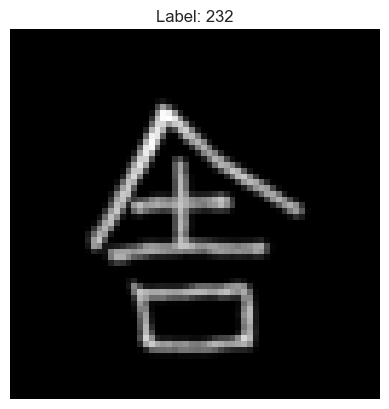

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

img, label = a[5012]      # get transformed tensor (after __getitem__)
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


### Splitting the data into train, val, test sets

In [10]:
from sklearn.model_selection import train_test_split

# first split train vs temp (val+test)
train_data, temp_data = train_test_split(path_label_list[:70000], test_size=0.3, random_state=42, stratify=[d[1] for d in path_label_list[:70000]]) # used stratify to preserve the same class proportions

# then split temp into val and test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=[d[1] for d in temp_data])


In [11]:
train_dataset = ImageDataset(train_data, transform)
val_dataset   = ImageDataset(val_data, transform)
test_dataset  = ImageDataset(test_data, transform)


### Data Loader

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, num_workers=0)


TEST

In [13]:
imgs, labels = next(iter(train_loader))
print(imgs.shape)    # [32, 1, 64, 64]
print(labels.shape)  # [32]


torch.Size([32, 1, 64, 64])
torch.Size([32])


### Check data leakage

In [29]:
# train_paths = [img[0] for img, _ in train_loader.dataset] if isinstance(train_loader.dataset[0], tuple) else [train_loader.dataset.data[i][0] for i in range(len(train_loader.dataset))]
# val_paths   = [img[0] for img, _ in val_loader.dataset]   if isinstance(val_loader.dataset[0], tuple)   else [val_loader.dataset.data[i][0] for i in range(len(val_loader.dataset))]
#
# # Turn them into sets
# train_set = set(train_paths)
# val_set = set(val_paths)
#
# # Check for overlap
# overlap = train_set.intersection(val_set)
# print(f"Overlap count: {len(overlap)}")
#
# if len(overlap) > 0:
#     print("Example overlap paths:", list(overlap)[:5])
# else:
#     print("✅ No data leakage detected between train and validation sets!")


Overlap count: 0
✅ No data leakage detected between train and validation sets!


In [30]:
# import time
# t0 = time.time()
# images, labels = next(iter(train_loader))
# print(f"Loaded one batch in {time.time() - t0:.2f} seconds")
# print("Batch shape:", images.shape, "Labels:", labels.shape)


Loaded one batch in 0.07 seconds
Batch shape: torch.Size([32, 1, 64, 64]) Labels: torch.Size([32])


### Model training

In [14]:
@torch.no_grad()
def evaluate(model, loader):
    """Compute accuracy of a model on a given DataLoader."""
    model.eval()                          # evaluation mode (no dropout, batchnorm updates)
    correct, total = 0, 0
    for images, labels in loader:
        outputs = model(images)            # forward pass
        preds = outputs.argmax(1)          # highest logit = predicted class
        correct += (preds == labels).sum().item()
        total += labels.numel()
    acc = correct / total
    return acc


In [15]:
@torch.no_grad()              # we don’t need gradients for validation
def calc_val_loss(model, val_loader, criterion):
    model.eval()              # turn off dropout/batchnorm updates
    total_loss = 0.0
    total_samples = 0

    for images, labels in val_loader:
        outputs = model(images)            # forward pass only
        loss = criterion(outputs, labels)  # compute loss for the batch
        total_loss += loss.item() * images.size(0)
        total_samples += labels.size(0)

    avg_val_loss = total_loss / total_samples
    return avg_val_loss


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 64x64 -> 62x62 (no padding)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0, stride=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # 62→31

        # 31x31 -> 15x15
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        # 15x15 -> 7x7
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.drop  = nn.Dropout(0.2)
        self.fc    = nn.Linear(128 * 7 * 7, num_classes)


    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.flatten(1)      # [B, 128*7*7]
        x = self.drop(x)
        return self.fc(x)

In [ ]:
# === setup ===
device = torch.device("cpu")   # change to "cuda" if you fix your GPU
num_classes = 956              # for example

model = CNN_1(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

# assume you already have a DataLoader
# for example: train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

train_losses = []
val_losses = []

best_acc = 0.0  # start with 0
best_path = "best_model2.pt"

# === training loop ===
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # move to device
        images, labels = images.to(device), labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    val_acc = evaluate(model, val_loader)
    val_loss = calc_val_loss(model, val_loader, criterion)
    # ---- store both ----
    train_losses.append(avg_loss)
    val_losses.append(val_loss)

    # print(f"Epoch {epoch+1}: Train loss = {avg_loss:.4f}, Val acc = {val_acc*100:.2f}%")
    print(f"Epoch {epoch+1}: train_loss={avg_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

    # --- check if this is the best so far ---
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f"✅ New best model saved (acc={best_acc:.4f})")

    # print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")

print("✅ Training complete!")

In [22]:
import torch.nn as nn
import torch.nn.functional as F
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        return self.block(x)

In [23]:
class CNN_Improved(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 64x64 -> 32x32
        self.block1 = ConvBlock(1, 32)
        # 32x32 -> 16x16
        self.block2 = ConvBlock(32, 64)
        # 16x16 -> 8x8
        self.block3 = ConvBlock(64, 128)

        self.gap  = nn.AdaptiveAvgPool2d(1)   # 8x8 -> 1x1
        self.drop = nn.Dropout(0.3)
        self.fc   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)          # [B, 128, 8, 8]
        x = self.gap(x)             # [B, 128, 1, 1]
        x = torch.flatten(x, 1)     # [B, 128]
        x = self.drop(x)
        x = self.fc(x)
        return x

In [ ]:
import torch
import torch.nn as nn

# ======================
#  Funkcja walidacyjna
# ======================
@torch.no_grad()
def eval_model(model, loader, criterion, device):
    """Zwraca (avg_val_loss, val_accuracy)."""
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size

        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples
    return avg_loss, acc


# ======================
#  Setup
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = 956
model = CNN_Improved(num_classes).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # ewentualnie + weight_decay

EPOCHS = 50

train_losses = []
val_losses = []
val_accuracies = []

best_acc = 0.0
best_path = "best_model3.pt"
checkpoint_path = "cnn_kanji_checkpoint3.pt"   # full checkpoint z historią


# ======================
#  Pętla treningowa
# ======================
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total_train_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        total_train_samples += batch_size

    avg_train_loss = running_loss / total_train_samples

    # --- walidacja ---
    val_loss, val_acc = eval_model(model, val_loader, criterion, device)

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"train_loss={avg_train_loss:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_acc={val_acc*100:.2f}%"
    )

    # --- zapis najlepszego modelu (tylko wagi) ---
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f"✅ New best model saved (acc={best_acc:.4f})")

    # --- pełny checkpoint po każdej epoce (opcjonalnie można rzadziej) ---
    checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "best_acc": best_acc,
        # przydatne hiperparametry:
        "num_classes": num_classes,
        "learning_rate": 2e-3,
        "label_smoothing": 0.1,
        "model_name": "CNN_Improved_v1",
    }
    torch.save(checkpoint, checkpoint_path)

print("✅ Training complete!")
print(f"Best val_acc = {best_acc*100:.2f}%")

Using device: cpu


In [ ]:
# checkpoint = torch.load("cnn_kanji_checkpoint.pt", map_location=device)
#
# model = CNN_Improved(checkpoint["num_classes"]).to(device)
# model.load_state_dict(checkpoint["model_state_dict"])
#
# optimizer = torch.optim.Adam(model.parameters(), lr=checkpoint["learning_rate"])
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
#
# train_losses = checkpoint["train_losses"]
# val_losses = checkpoint["val_losses"]
# val_accuracies = checkpoint["val_accuracies"]
# start_epoch = checkpoint["epoch"]
# best_acc = checkpoint["best_acc"]


In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'train_losses' is not defined

<Figure size 800x500 with 0 Axes>

In [29]:
# load weights
model = CNN_1(956)
model.load_state_dict(torch.load("best_model.pt", map_location="cpu"))
model.eval()

CNN_1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=6272, out_features=956, bias=True)
)

In [31]:
tfm = T.Compose([
    T.Resize((64,64)),
    T.ToTensor(),
    T.Normalize([0.5],[0.5])
])


In [32]:
correct, total = 0, 0
test_loss = 0.0
loss_fn = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for x, y in test_loader:              # <- your existing DataLoader
        logits = model(x)
        test_loss += loss_fn(logits, y).item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += x.size(0)

print(f"Test acc: {100*correct/total:.2f}% | Test loss: {test_loss/total:.4f}")

Test acc: 94.50% | Test loss: 0.2827


In [140]:
img_path = "C:\\Users\\alicj\\PycharmProjects\\KanjiRecognitionModel\\data\\ETL8G\\ETL8G_28_unpack\\00811.png"   # 👈 your own image
img = Image.open(img_path).convert("L")  # "L" = grayscale
x = tfm(img).unsqueeze(0)     # -> shape [1,1,64,64]


In [141]:
with torch.no_grad():
    logits = model(x)
    pred = logits.argmax(1).item()      # predicted class index
    probs = F.softmax(logits, dim=1)    # optional, to see confidence
    confidence = probs[0, pred].item()

print(f"Predicted class index: {pred}  |  confidence: {confidence:.2f}")


Predicted class index: 811  |  confidence: 0.93


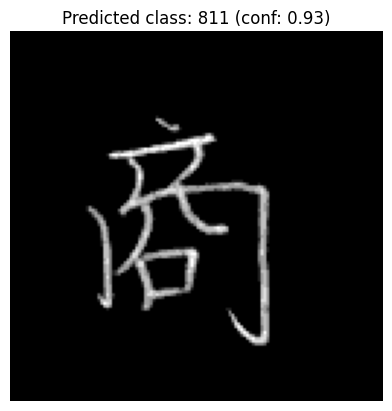

In [142]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap="gray")
plt.title(f"Predicted class: {pred} (conf: {confidence:.2f})")
plt.axis("off")
plt.show()


In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        logits = model(x)
        preds = logits.argmax(1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print(classification_report(all_labels, all_preds, digits=3))   # precision/recall/F1 per class

cm = confusion_matrix(all_labels, all_preds)                    # (956 x 956) matrix
# You can save cm to disk for plotting elsewhere:
np.save("confusion_matrix.npy", cm)


              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     0.750     0.857         4
           2      1.000     1.000     1.000         3
           3      1.000     1.000     1.000         3
           4      1.000     1.000     1.000         4
           5      1.000     1.000     1.000         3
           6      0.667     0.667     0.667         3
           7      1.000     1.000     1.000         3
           8      0.750     1.000     0.857         3
           9      1.000     1.000     1.000         3
          10      1.000     1.000     1.000         3
          11      1.000     1.000     1.000         3
          12      0.667     0.667     0.667         3
          13      1.000     0.667     0.800         3
          14      1.000     1.000     1.000         4
          15      1.000     1.000     1.000         3
          16      1.000     1.000     1.000         3
          17      1.000    

In [65]:
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
low_f1 = {label: stats for label, stats in report.items()
          if label.isdigit() and stats["f1-score"] < 0.6}

print(f"Liczba klas z F1 < 0.7: {len(low_f1)}\n")

for label, stats in low_f1.items():
    print(f"Klasa {label}: F1={stats['f1-score']:.3f}, "
          f"Precision={stats['precision']:.3f}, Recall={stats['recall']:.3f}")


Liczba klas z F1 < 0.7: 8

Klasa 123: F1=0.400, Precision=0.500, Recall=0.333
Klasa 201: F1=0.400, Precision=1.000, Recall=0.250
Klasa 281: F1=0.571, Precision=0.500, Recall=0.667
Klasa 289: F1=0.500, Precision=1.000, Recall=0.333
Klasa 399: F1=0.500, Precision=1.000, Recall=0.333
Klasa 865: F1=0.500, Precision=1.000, Recall=0.333
Klasa 871: F1=0.500, Precision=1.000, Recall=0.333
Klasa 903: F1=0.500, Precision=1.000, Recall=0.333


In [55]:
import numpy as np

cm = np.load("confusion_matrix.npy")
print("Shape:", cm.shape)


Shape: (956, 956)


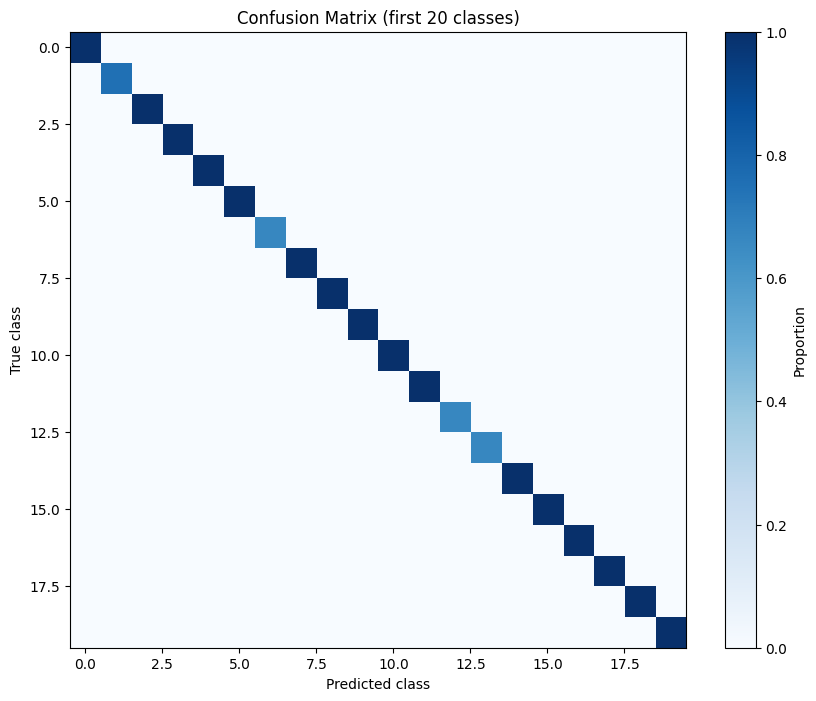

In [56]:
import matplotlib.pyplot as plt

# normalize per true class
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
plt.imshow(cm_norm[:20, :20], cmap="Blues")  # first 20 classes
plt.title("Confusion Matrix (first 20 classes)")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.colorbar(label="Proportion")
plt.show()


In [57]:
# ignore correct predictions (diagonal)
np.fill_diagonal(cm, 0)
i, j = np.unravel_index(cm.argmax(), cm.shape)
print(f"Most confused: true class {i} → predicted as {j} ({cm[i,j]} times)")


Most confused: true class 399 → predicted as 495 (2 times)


In [4]:
import torch

model = CNN_1(956)
model.load_state_dict(torch.load("best_model.pt", map_location="cpu"))
model.eval()


CNN_1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=6272, out_features=956, bias=True)
)

In [45]:
from PIL import Image
from torchvision import transforms
import torch
import torchvision.transforms as T

# Load your image
img_path = "C:\\Users\\alicj\\PycharmProjects\\KanjiRecognitionModel\\test_data\\d.jpg"
img_path2 = "C:\\Users\\alicj\\PycharmProjects\\KanjiRecognitionModel\\data\\ETL8G\\ETL8G_33_unpack\\00021.png"
image = Image.open(img_path).convert("L")

transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

# Apply the transforms
input_tensor = transform(image).unsqueeze(0)  # shape: [1, 3, 224, 224]


In [46]:
with torch.no_grad():
    output = model(input_tensor)
    prediction = torch.argmax(output, dim=1)


In [47]:
print("Predicted class index:", prediction.item())


Predicted class index: 471


NameError: name 'confidence' is not defined

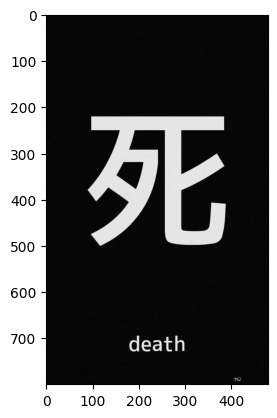

In [48]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap="gray")
plt.title(f"Predicted class: {prediction} (conf: {confidence:.2f})")
plt.axis("off")
plt.show()


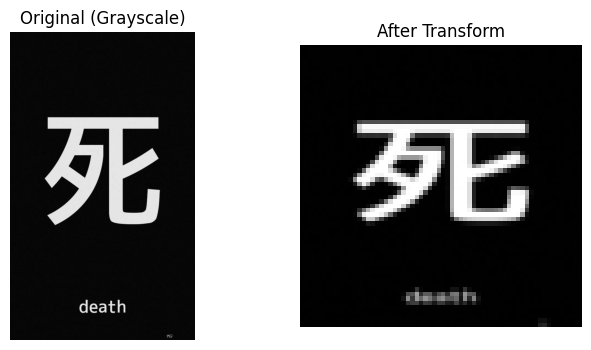

In [49]:
# ---- Undo normalization for display ----
def unnormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 1, 1)
    std = torch.tensor(std).view(1, 1, 1)
    return tensor * std + mean

unnorm = unnormalize(input_tensor[0], [0.5], [0.5])  # remove batch dim, undo norm
unnorm = torch.clamp(unnorm, 0, 1)

# ---- Show original vs transformed ----
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original (Grayscale)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(unnorm.squeeze(0), cmap='gray')
plt.title("After Transform")
plt.axis("off")

plt.show()

In [51]:
import torch.nn as nn

last_conv_name = None
for name, m in model.named_modules():
    if isinstance(m, nn.Conv2d):
        last_conv_name = name

assert last_conv_name is not None, "No Conv2d layers found in the model."
print("Using target layer:", last_conv_name)


Using target layer: conv3


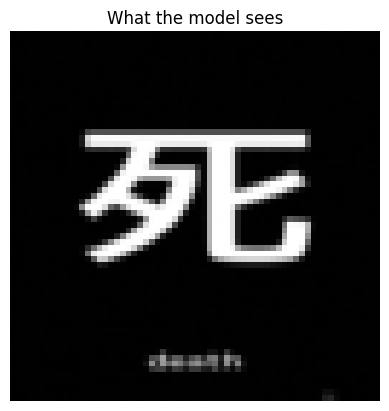

In [53]:
import torch
import matplotlib.pyplot as plt

def unnormalize_gray(x, mean=0.5, std=0.5):
    return torch.clamp(x * std + mean, 0, 1)

# input_tensor: [1,1,64,64]
view_img = unnormalize_gray(input_tensor[0,0]).cpu()
plt.imshow(view_img, cmap='gray'); plt.title("What the model sees"); plt.axis('off'); plt.show()


In [54]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def occlusion_map(model, x, target=None, patch=8, stride=4, fill=0.0):
    """
    x: [1,1,H,W] normalized input
    target: int class index. If None, use model's top1 on x.
    patch: occlusion square size
    stride: sliding stride
    fill: value to fill (use 0.0 for normalized 'mid-gray'; or use x.mean().item())
    """
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        if target is None:
            target = probs.argmax(1).item()
        base = probs[0, target].item()

    _, _, H, W = x.shape
    heat = torch.zeros((H, W), dtype=torch.float32)

    for i in range(0, H - patch + 1, stride):
        for j in range(0, W - patch + 1, stride):
            x_occ = x.clone()
            x_occ[:, :, i:i+patch, j:j+patch] = fill
            with torch.no_grad():
                p = F.softmax(model(x_occ), dim=1)[0, target].item()
            drop = base - p
            heat[i:i+patch, j:j+patch] += drop

    # normalize heat to [0,1]
    heat -= heat.min()
    if heat.max() > 0: heat /= heat.max()
    return heat, target, base

heat, target, base = occlusion_map(model, input_tensor, target=None, patch=8, stride=4, fill=0.0)

img_vis = unnormalize_gray(input_tensor[0,0]).cpu()
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img_vis, cmap='gray'); plt.title("Input"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_vis, cmap='gray'); plt.imshow(heat, alpha=0.5); plt.title(f"Occlusion (class {target}, p0={base:.2f})"); plt.axis('off')
plt.show()


RuntimeError: cannot register a hook on a tensor that doesn't require gradient

In [55]:
import torch.nn as nn
from torchcam.methods import GradCAM
import torch.nn.functional as F
import matplotlib.pyplot as plt

# find last Conv2d name
last_conv_name = None
for name, m in model.named_modules():
    if isinstance(m, nn.Conv2d):
        last_conv_name = name
assert last_conv_name, "No Conv2d layers found."

cam_extractor = GradCAM(model, target_layer=last_conv_name)
model.eval(); model.zero_grad()
scores = model(input_tensor)                 # [1,C]
target = scores.argmax(1).item()
cams = cam_extractor(target, scores)         # list of CAMs
cam = cams[0]                                # [h,w] (smaller than input)

# resize to input size
cam = cam / (cam.max() + 1e-8)
cam_r = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=input_tensor.shape[-2:], mode='bilinear', align_corners=False)[0,0]

img_vis = unnormalize_gray(input_tensor[0,0]).cpu()
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img_vis, cmap='gray'); plt.title("Input"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_vis, cmap='gray'); plt.imshow(cam_r.cpu(), alpha=0.5); plt.title(f"Grad-CAM (class {target})"); plt.axis('off')
plt.show()


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [1, 15, 15] and output size of torch.Size([64, 64]). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcam.methods import GradCAM
import matplotlib.pyplot as plt

model.eval()

# 1) Make sure grad is enabled
torch.set_grad_enabled(True)

# 2) Find last conv layer name
last_conv = None
for name, m in model.named_modules():
    if isinstance(m, nn.Conv2d):
        last_conv = name
assert last_conv, "No Conv2d found"
print("Using target layer:", last_conv)

# 3) DO NOT use torch.no_grad() here
model.zero_grad()
cam_extractor = GradCAM(model, target_layer=last_conv)

scores = model(input_tensor)                 # [1, C]; keep this out of no_grad
target = scores.argmax(1).item()

cams = cam_extractor(target, scores)         # list of CAMs
cam = cams[0]                                # [h, w]
cam = cam / (cam.max() + 1e-8)

# 4) Resize CAM to input size and overlay (grayscale, 64x64)
cam_r = F.interpolate(cam.unsqueeze(0).unsqueeze(0),
                      size=input_tensor.shape[-2:], mode='bilinear',
                      align_corners=False)[0,0]

# Unnormalize for display if you used mean=std=0.5
def unnorm_gray(x):  # x: [H,W] normalized
    return torch.clamp(x*0.5 + 0.5, 0, 1)

img_vis = unnorm_gray(input_tensor[0,0]).cpu()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img_vis, cmap='gray'); plt.title("Input"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_vis, cmap='gray'); plt.imshow(cam_r.cpu(), alpha=0.5); plt.title(f"Grad-CAM (class {target})"); plt.axis('off')
plt.show()


Using target layer: conv3


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [1, 15, 15] and output size of torch.Size([64, 64]). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [24]:
from collections import Counter

val_labels = [d[1] for d in val_data]
counts = Counter(val_labels)
print(len(val_labels), "examples total")
print("Min samples per class in val:", min(counts.values()))


10500 examples total
Min samples per class in val: 10


In [4]:
import torch
# Tworzysz nową instancję modelu
model = CNN_1(num_classes=956)

# Ładujesz zapisane wagi
state = torch.load("best_model.pt", map_location=torch.device("cpu"))
model.load_state_dict(state)

model.eval()

CNN_1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=6272, out_features=956, bias=True)
)

In [19]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Accuracy na zbiorze testowym: {accuracy:.2f}%")


Accuracy na zbiorze testowym: 95.61%


In [20]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted = outputs.argmax(dim=1)

        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())


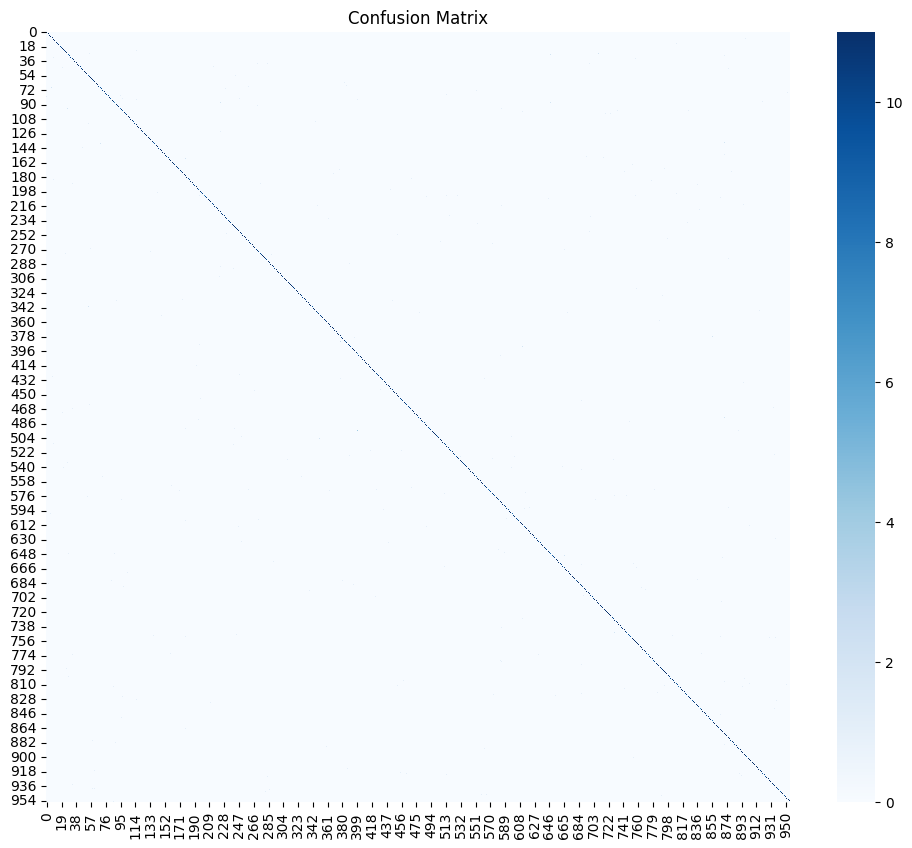

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [24]:
import numpy as np

errors = np.where(np.array(y_true) != np.array(y_pred))[0]
print("Liczba błędów:", len(errors))


Liczba błędów: 461


In [25]:
import numpy as np

cm = confusion_matrix(y_true, y_pred)
most_confused = np.argsort(cm.max(axis=1))[-10:]  # 10 najgorszych klas
print("Najczęściej mylone klasy:", most_confused)


Najczęściej mylone klasy: [385 386 387 389 391 392 393 394 382 477]


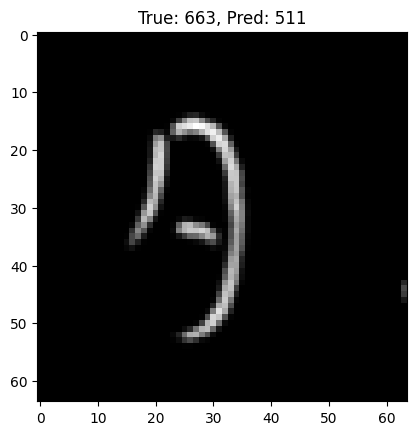

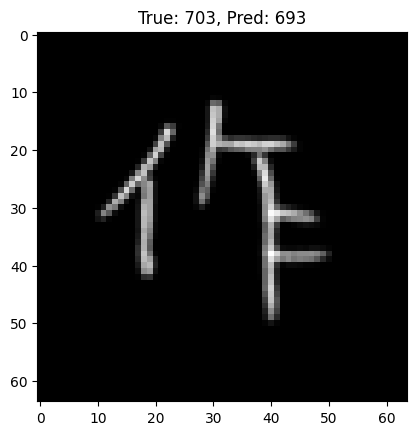

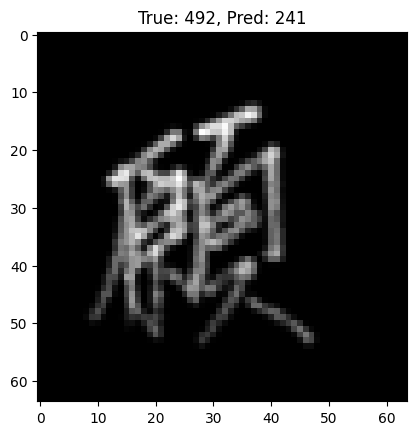

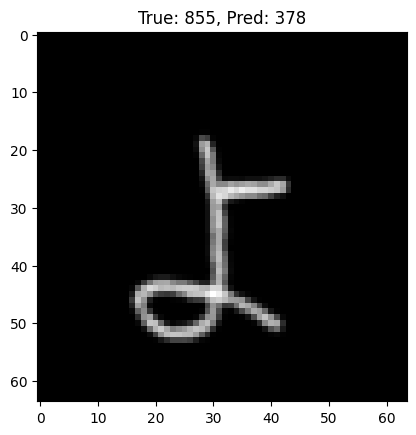

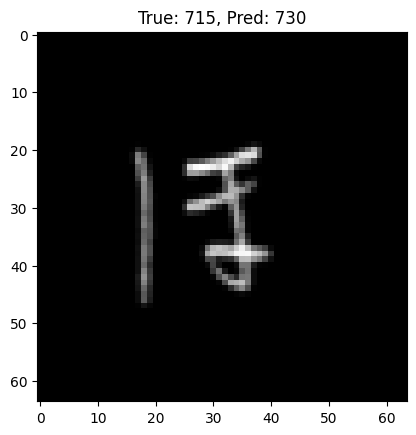

In [26]:
import matplotlib.pyplot as plt

errors = [(true, pred, idx) for idx, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]

for i in range(5):  # pierwsze 5 błędów
    true, pred, idx = errors[i]
    img, _ = test_dataset[idx]
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"True: {true}, Pred: {pred}")
    plt.show()


In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.91      0.95        11
           2       0.92      1.00      0.96        11
           3       0.92      1.00      0.96        11
           4       0.92      1.00      0.96        11
           5       0.92      1.00      0.96        11
           6       0.85      1.00      0.92        11
           7       0.92      1.00      0.96        11
           8       1.00      0.82      0.90        11
           9       0.73      1.00      0.85        11
          10       0.92      1.00      0.96        11
          11       1.00      0.91      0.95        11
          12       0.92      1.00      0.96        11
          13       1.00      1.00      1.00        11
          14       1.00      0.91      0.95        11
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00        11
          17       1.00    

In [28]:
# Kopia macierzy bez przekątnej (tam nie ma błędów)
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# Znajdź indeksy 5 największych wartości
mis_idx = np.dstack(np.unravel_index(np.argsort(cm_no_diag.ravel())[-5:], cm_no_diag.shape))[0]


In [29]:
print("Top 5 najczęściej mylonych par:")
for true_c, pred_c in mis_idx[::-1]:   # od największej pomyłki
    print(f"Prawdziwa klasa: {true_c}  →  Model przewidział: {pred_c}  (liczba błędów: {cm[true_c, pred_c]})")


Top 5 najczęściej mylonych par:
Prawdziwa klasa: 839  →  Model przewidział: 327  (liczba błędów: 7)
Prawdziwa klasa: 399  →  Model przewidział: 495  (liczba błędów: 5)
Prawdziwa klasa: 495  →  Model przewidział: 399  (liczba błędów: 4)
Prawdziwa klasa: 384  →  Model przewidział: 377  (liczba błędów: 3)
Prawdziwa klasa: 840  →  Model przewidział: 238  (liczba błędów: 3)
